# **Federico Matteoni - Assignment 4**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.future import graph
from skimage.metrics import structural_similarity

The code has beed splitted into three main sections

# Segmentation
The **first section** implements the **image segmentation**.
It's realized with the SEEDS algorithm to compute the superpixels, from the OpenCV library, and with the NCut implementation provided by the scikit-image library.

The segmented are color coded with the colors of the image dataset, but the colors are assigned without respecting the original classification. The colors are used just to mark the detected blobs, and not to classify the blobs according to their shape or content. This is done on the basis of the mean color of adiacent blobs, joining the areas with similar color.

This generate behaviors that are discussed in the comments section.

In [2]:
def get_superpixels(image, iter = 10, prior = 5, n_superpixels = 350, n_levels = 20, n_bins = 20, print_intermediate=True, intermediate_name='result.jpg'):
    converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    height, width, channels = converted_image.shape

    # all white image used to show the computed superpixels superimposed on the original image
    mask_img = np.zeros((height, width, 3), np.uint8)
    mask_img[:] = (255, 255, 255)

    # SEEDS object creation and iterations
    seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, n_superpixels, n_levels, prior, n_bins)
    seeds.iterate(converted_image, iter)

    # computed superpixels
    labels = seeds.getLabels()
    mask = seeds.getLabelContourMask(False)

    if (print_intermediate):  # shows the superpixels over the original image
        mask_inv = cv2.bitwise_not(mask)
        result_bg = cv2.bitwise_and(image, image, mask = mask_inv)
        result_fg = cv2.bitwise_and(mask_img, mask_img, mask = mask)
        result = cv2.add(result_bg, result_fg)
        cv2.imwrite(intermediate_name, result)

    return labels

In [3]:
def ncut(image, labels):
    # RAG computed based on the mean color of the superpixels
    rag = graph.rag_mean_color(image, labels, mode='similarity', sigma=512.0)

    # cuts the regions producing the segmentation
    new_labels = graph.ncut(labels, rag)
    return new_labels

In [10]:
def save_segmentation(image, labels, name='ncut.jpg'):
    # colors from the dataset
    color_list = [(0,0,0), (128,0,0), (0,128,0), (128,128,0), (0,0,128), (128,0,128), (0,128,128), (128,128,128), (64,0,0), (192,0,0), (64,128,0), (192,128,0), (64,0,128), (192,0,128)]

    # assign to each region a color from the list cycling through it
    out = color.label2rgb(labels, image, kind='overlay', bg_label=0, colors=color_list, alpha=1)
    cv2.imwrite(name, out)

In [11]:
for imagefile in os.listdir(path="./"):
    if (imagefile[-3:] == "bmp"):
      if (imagefile[-6:] != "GT.bmp"):
          if not os.path.exists("computedset/img_" + imagefile[0] + "_segm"): os.mkdir("computedset/img_" + imagefile[0] + "_segm")
          if not os.path.exists("computedset/img_" + imagefile[0] + "_interm"): os.mkdir("computedset/img_" + imagefile[0] + "_interm")
          print("\rSegmenting " + imagefile[:-4], end=" ")
          image = cv2.imread("./" + imagefile)
          labels = get_superpixels(image, intermediate_name="computedset/img_" + imagefile[0] + "_interm/" + imagefile)
          new_labels = ncut(image, labels)
          save_segmentation(image, new_labels, name = "computedset/img_" + imagefile[0] + "_segm/" + imagefile)
print("Segmentation ended")

Segmenting 6_19_s Segmentation ended


# Comparison
The second part of the code computes the differences between the computed segmentation of the images and the ground truths provided by the dataset.

The difference between the images are computed with the structural similarity metric, implemented in the scikit-image library.

In [16]:
def compare(image1, image2):
    return structural_similarity(image1, image2, channel_axis=2, gradient=False, full=False, multichannel=True)

In [17]:
print("Computing differences with ground truths")
result = {}
for dir in os.listdir(path="computedset/"):
    if (dir[-4:] == "segm"):
        for imagefile in os.listdir(path="computedset/" + dir):
            print("\rComparing " + imagefile[:-4], end=" ")
            image1 = cv2.imread("computedset/" + dir + "/" + imagefile)
            image2 = cv2.imread("./" + imagefile[:-4] + "_GT.bmp")
            metric_value = compare(image1, image2)
            result[imagefile[:-4]] = metric_value
result = {k:v for k, v in sorted(result.items(), key = lambda item : item[1], reverse=True)}
per_class = [0, 0, 0, 0, 0, 0, 0, 0]
for k in result:
    per_class[int(k[0]) - 1] += result[k]
print("")

Computing differences with ground truths
Comparing 8_25_s 


# Output
After computing the structural similarity, we output the mean similarity per each class and the best and worst 5 images.

In [18]:
def save_SSIM_image(image1, image2, filename):
    img = structural_similarity(image1, image2, channel_axis=2, gradient=False, full=True, multichannel=True)[1]
    img = (img*255).astype("uint8")
    cv2.imwrite(filename, img)

In [19]:
print("Mean metric per class")
for i in range(8):
    per_class[i] /= 30
    print("\tClass " + str(i+1) + "\t" + str(per_class[i]))

print("Top 5")
if not os.path.exists("computedset/top"): os.mkdir("computedset/top")
i = 0
for k in result:
    print("\t" + k + "\t" + str(result[k]))
    image1 = cv2.imread("computedset/img_" + k[0] + "_segm/" + k + ".bmp")
    image2 = cv2.imread("./" + k + "_GT.bmp")
    img = save_SSIM_image(image1, image2, "computedset/top/" + k + "_ssim.bmp")
    i += 1
    if i == 5: break

result = {k:v for k, v in sorted(result.items(), key = lambda item : item[1], reverse=False)}
print("Flop 5")
if not os.path.exists("computedset/flop"): os.mkdir("computedset/flop")
i = 0
for k in result:
    print("\t" + k + "\t" + str(result[k]))
    image1 = cv2.imread("computedset/img_" + k[0] + "_segm/" + k + ".bmp")
    image2 = cv2.imread("./" + k + "_GT.bmp")
    img = save_SSIM_image(image1, image2, "computedset/flop/" + k + "_ssim.bmp")
    i += 1
    if i == 5: break

Mean metric per class
	Class 1	0.5763830993916695
	Class 2	0.22739345158364987
	Class 3	0.3506715210332968
	Class 4	0.3530935505937389
	Class 5	0.5580125641677065
	Class 6	0.5725177602936065
	Class 7	0.44255445422087175
	Class 8	0.4794470933290634
Top 5
	6_29_s	0.8003920292788207
	5_15_s	0.7869081255226901
	6_4_s	0.7563312156312917
	5_20_s	0.7560069053760937
	8_12_s	0.746023112045591
Flop 5
	2_21_s	0.032935226946613695
	2_7_s	0.06823542767886605
	2_6_s	0.0695247723423181
	2_22_s	0.08922034898210662
	3_19_s	0.10199576696829545


# Results

The two images with the best evaluation are 6_29 and 5_15. Below are the original images, computed segmentations and ground truth of both images.

#### 6_29
Similarity of 80.03% with respect to ground truth

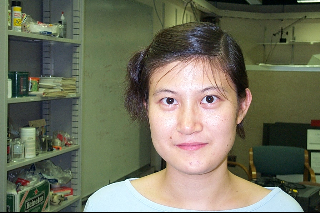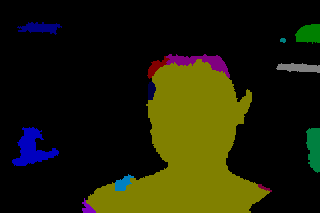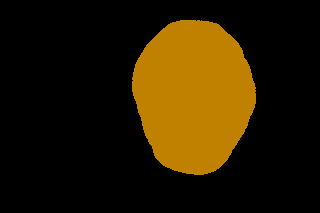

####5_15
Similarity of 78.69% with respect to ground truth

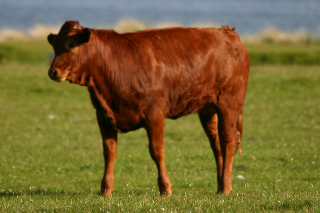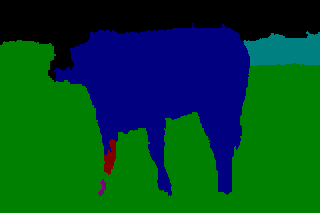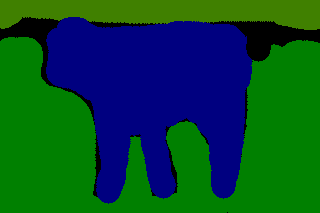

From both computed segmentations we can already derive the classes of the images, clearly showing the shilouette of a head in 6_29 and the shilouette of a cow in 5_15.

In 6_9 we can see how the segmentation correctly detected the face of the girl, helped by the contrast with the background. The segmentation detects areas of high-contrast in other regions of the image, for example in the shelf on the left and the more illuminated areas on the right.

In 5_15 we can clearly derive the correct shilouette of the cow, and the segmentation correctly identified the difference between the grass and the sky in the background.

The red area on the segmentation of the cow is due to the difference in contrast and color between the upper part of the leg, which is shadowed, and the lower part, in direct sunlight. This tricks the segmentation algorithm into keeping the division between the two areas, and thus assigning another color to it.
A similar behavior is found the the segmentation of the girl's face, where the algorithm keeps the division between the segments with the color of the face and the segments with the color of the hair, thus assigning different colors to each.

The two images with the worst evaluation are 2_21 and 2_7. Below are the original images, computed segmentations and ground truth of both images.

#### 2_21
Similarity of 3.29% with respect to the ground truth

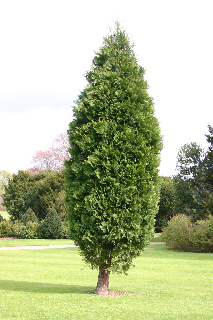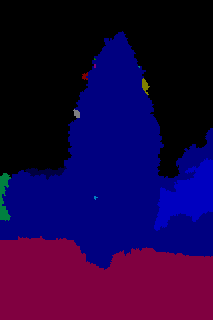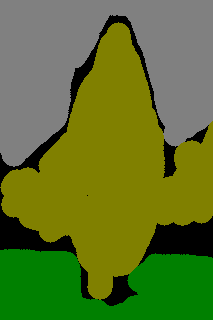

#### 2_7
Similarity of 6.82% with respect to the ground truth

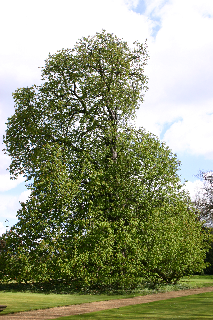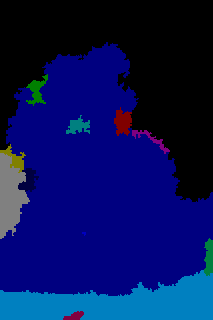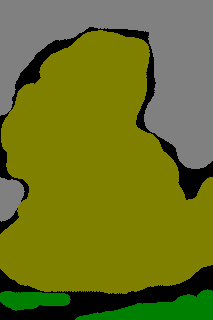

In both cases we are presented with a fairly low-contrast image, with both trees composed of bright green presented against a very brigth sky as the background. 

In 2_21, apart from the tree stump, the image segmentation correctly identifies the shape of the tree and segments it accordingly. The main difference is the assigned color: given that the algorithm used doesn't learn the correct classification of the areas of the image but just assigns a color from a given list, the problem here is the chosen color which is fairly different from the correctly assigned color in the ground truth image. This lowers a lot the similarity between the two images, and given that the algorithm used a dark blue instead of a bright color this would lower the similarity metric even if the two image are compared in grayscale.

In 2_27 we have a similar situation, with the main identified area colored in dark blue and, thus, not correctly comparing with the bright color assigned in the ground truth. But, as with 2_21, we can see how the algorithm correctly caputred the shape of the tree, although it has been tricked once again by some bright spots where the background sky filters between the leafs. The metric is higher probably because of the grey patch identified and, luckily, correctly colored on the left, which we can find, altough smaller, in the ground truth image.

We can confirm this by looking at the SSIM images, which are the results of the comparison, where a pixel is the brighter the more similar are the corresponding pixels in each image. For example, the comparison between the computed segmentation of 2_21 and its groud truth is the following:

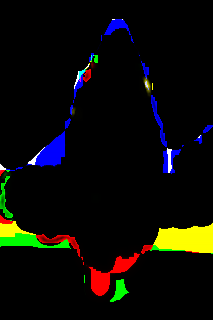

We can see the dark patch exactly where both the computed segmentation and the ground truth detects the tree. The shape is correct, but the colors are not. The blue contour correspond to the black contour in the ground truth, which is present also in the computed segmentation.

A similar comparison can be made for 6_29:

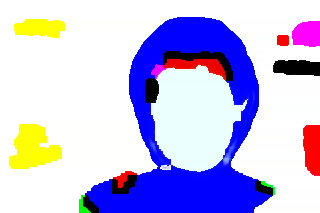

The white patches are where the two images correspond exactly. The face is correctly detected, slightly bluish due to the color difference, and the aura around the face is a mix of the uncorrectly segmented upper torso and the missing top part of the head in the computed segmentation.

### Personal Considerations

The two main weak points I have found are the following and are already been highlighted in the previous comments.

The main problem is that the algorithm doesn't learn the correct color to assign to the areas it detects, thus assigning the colors taking them from a given list and cycling through it. This means that even if the algorithm correctly identify a shape in an image, it may be evaluated poorly uncorrectly due to the choice of the colour and even worse if it picks a dark color instead of a bright one or viceversa. This may be tackled in the following way:
*   Randomly shuffle the color list
*   Assign the color
*   Evaluate with the given metric
*   Repeat

By doing this, we may stumble upon a (or some) color assignment that maximize the evaluation metric, and stop after a certain number of tries or when a desired metric value has been found.

The second main problem is that the areas are detected based on the mean color contained in them, instead of the shape. This is linked to the previous problem, as the algorithm doesn't learn the shapes and, in addition to not assign the correct color, may assign different color to areas beloning to the same feature of the image for example just because that feature is shadowed.

To realize this assignment I've explored both the Scikit and the OpenCV libraries and compared different algorithms (for instance, SEEDS and SLIC for the superpixels computation) and metrics (both MSE and structural similarity), gaining insights in the tools provided by these libraries.